# Probabilistic PCA

Here is my probabilistic PCA implementation based on equations from "Pattern Recognition and Machine Learning" by C. Bishop book.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from keras.datasets import mnist

Using TensorFlow backend.


## Prepare dataset
The dataset is a MNIST dataset. We choose two digits '1' and '8'.

In [19]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255
x_train = x_train.reshape(60000, -1)
x_train = x_train[((y_train == 8) + (y_train == 1)),:]
y_train = y_train[((y_train == 8) + (y_train == 1))]

## Probabilistic PCA class
This is the abstract class, that two child class will inherti from

In [20]:
class PPCA():
    '''
    X - dataset
    x - data point
    z - laten variable
    
    '''
    def __init__(self,X, M):
        self.D = X.shape[1] # dimension of oryginal data points   
        self.M = M # dimension of reduced data point
        self.X = X #dataset
        self.calculate_parameters()
    def calculate_parameters(self):
        '''
        Determine parameteres of the model (mean, variance and W matrix). 
        Have to be overriden in child classes
        '''
        raise NotImplementedError 
    def sample_x(self):
        '''
        Sample from p(x) distribution
        '''
        mean = self.mean
        C = np.dot(self.W_ML, self.W_ML.T) + self.sigma * np.eye(self.D)
        distribution = stats.multivariate_normal(mean, C)
        return distribution.rvs()
    def sample_z(self):
        '''
        Sample from p(z) distribution
        '''
        model = stats.multivariate_normal(np.zeros(shape = self.M), np.eye(self.M))
        return distribution.rvs()
    def sample_x_given_z(self, z):
        '''
        Sample from p(x|z) distribution'
        '''
        distribution = stats.multivariate_normal(np.dot(self.W_ML, z) + self.mean, self.sigma * np.eye(self.D))
        return distribution.rvs()
    def sample_z_given_x(self, x):
        '''
        Sample from p(z|x) distribution
        '''
        M_matrix = np.dot(self.W_ML.T, self.W_ML) + self.sigma * np.eye(self.M)
        M_matrix_inv = np.linalg.inv(M_matrix)
        mean = np.linalg.multi_dot([M_matrix_inv, self.W_ML.T, (x - self.mean)])
        variance = self.sigma * M_matrix_inv                                    
        distribution = stats.multivariate_normal(mean, variance)
        return distribution.rvs()
                                       

## Closed-form solution (CF)

In [21]:
class PPCA_CF(PPCA):
    '''
    X - dataset
    x - data point
    z - laten variable
    
    '''        
    def calculate_parameters(self):
        '''
        Determine parameteres of the model by optimizing likelihood function. 
        It involves caltulating mean, variance and W matrix.
        '''
        self.mean = self.X.mean(axis = 0)
        
        covariance = np.cov(self.X, rowvar = False)
        eig_val, eig_vec = np.linalg.eig(covariance)
        idx = np.argsort(eig_val)[::-1]
        eig_val = np.real(eig_val[idx])
        eig_vec = np.real(eig_vec[:, idx])
        
        self.sigma = 1/(self.D - self.M) * np.sum(eig_val[self.M+1:])
        
        U_M = eig_vec[:, :self.M]
        L_M = np.diag(eig_val[:self.M])
        self.W_ML = np.dot(U_M, np.sqrt(L_M - self.sigma*np.eye(self.M)))
                                        
        
        

## Sample from p(x) distribution
Here we can see that algorithm can learn the distribution of data. It can generate '1' and '8' digits.

In [22]:
model = PPCA_CF(x_train, 10)

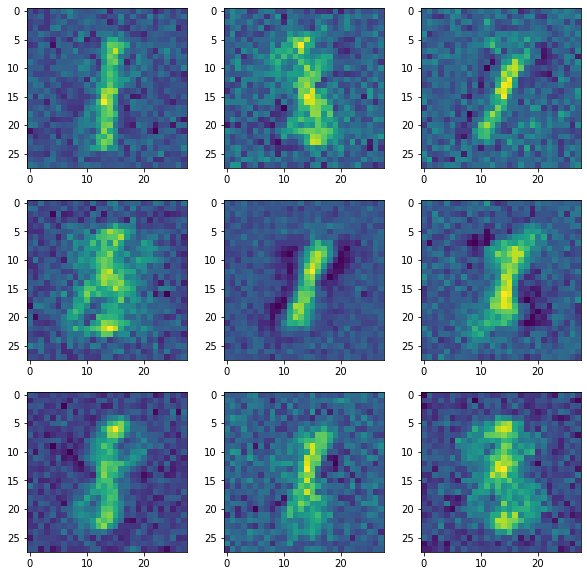

In [23]:
plt.figure(figsize =(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(model.sample_x().reshape(28,28))

## Show the original image

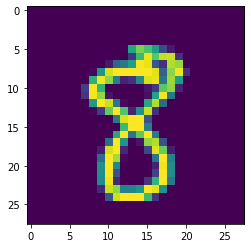

In [24]:
idx = np.random.randint(0, x_train[0].shape[0])
idx = 10
plt.imshow(x_train[idx,:].reshape(28,28))

## Show the reconstructions
Reconstructions are noisy due to variance matrix in $p(x|z)$ distribution

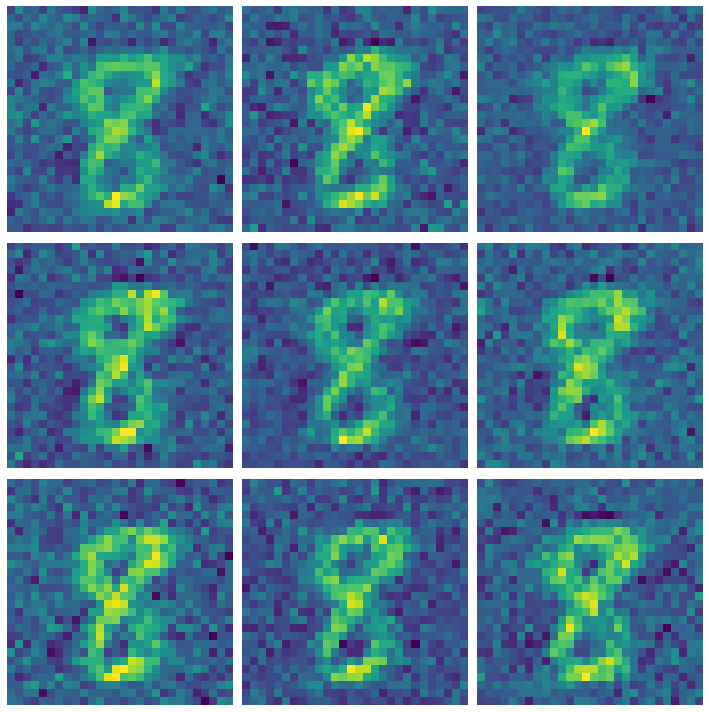

In [25]:
z = model.sample_z_given_x(x_train[idx,:]) # get latent variable

plt.figure(figsize =(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    image = model.sample_x_given_z(z)
    plt.imshow(image.reshape(28,28))
    plt.axis('off')
plt.tight_layout()
plt.savefig('featured.png')

# Expectation maximization algorithm
Model parameters can be also obtained using iterative expectation maximization algorithm (EM). This solution has few advantages over closed-form solution especially in situations when we have to deal with highly dimensional observed variables. That avoids evaluation of eigen vectors and eigen values of huge covariance matrix. 

## Implementation
This class can be used the same way as class of the closed-form. The only difference is the way the parameters of PPCA algorithm are obtained.

In [28]:
class PPCA_EM(PPCA):
    def calculate_parameters(self):
        '''
        Determine parameteres of the model by optimizing likelihood function. 
        It involves caltulating mean, variance and W matrix.
        '''
        
        self.W_ML = np.random.normal(0,1, size = (self.D, self.M)) # random initialization
        self.sigma = np.random.normal(0,1)
        
        self.mean = self.X.mean(axis = 0)
        
        for epoch in range(10):
            #E step
            M_matrix_inverse = np.linalg.inv(np.dot(self.W_ML.T, self.W_ML) + self.sigma * np.eye(self.M)) # shape self.M x self.M
            E_z_n = np.zeros(shape=(self.X.shape[0], self.M))
            E_zn_zn = np.zeros(shape = (self.X.shape[0], self.M, self.M))

            for i in range(self.X.shape[0]):
                E_z_n[i,:] = np.linalg.multi_dot([M_matrix_inverse, self.W_ML.T, self.X[i,:]-self.mean])
                E_zn_zn[i,:,:] = self.sigma * M_matrix_inverse + np.dot(E_z_n[i,:].reshape(-1,1), E_z_n[i,:].reshape(1,-1))
            # M step
            W_new_first = np.zeros(shape=(self.X.shape[0],self.X.shape[1], self.M))
            for i in range(self.X.shape[0]):
                W_new_first[i, :] = np.dot(self.X[i,:].reshape(-1,1), E_z_n[i,:].reshape(1,-1))
            W_new_first = W_new_first.sum(axis = 0)
            W_new_second = np.linalg.inv(np.sum(E_zn_zn,axis = 0))
            self.W_ML = np.dot(W_new_first, W_new_second)

            self.sigma = 0 
            for i in range(self.X.shape[0]):
                first_element = np.linalg.norm(self.X[i,:] - self.mean)**2
                second_element = -2 * np.linalg.multi_dot([E_z_n[i,:].reshape(1,-1), self.W_ML.T, self.X[i,:].reshape(-1,1) - self.mean.reshape(-1,1)])            
                third_element = np.matrix.trace(np.linalg.multi_dot([E_zn_zn[i,:,:], self.W_ML.T, self.W_ML]))
                self.sigma += (first_element + second_element + third_element) / (self.X.shape[0] * self.D)
            print('Epoch {}, sigma{}'.format(epoch, self.sigma))

     
        

model = PPCA_EM(x_train, 2)

Epoch 0, sigma[[0.04649501]]
Epoch 1, sigma[[0.03571244]]
Epoch 2, sigma[[0.03436299]]
Epoch 3, sigma[[0.03415415]]
Epoch 4, sigma[[0.03411655]]
Epoch 5, sigma[[0.03410826]]
Epoch 6, sigma[[0.03410605]]
Epoch 7, sigma[[0.03410538]]
Epoch 8, sigma[[0.03410516]]
Epoch 9, sigma[[0.03410509]]
